In [1]:
from datetime import datetime
from pathlib import Path

from astropy.time import Time
from astropy.coordinates import AltAz, SkyCoord, EarthLocation
from astropy import units as u
import hera_filters
from hera_qm import xrfi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import eigsep_data as ed

%matplotlib widget

In [2]:
start_acc = 200
end_acc = 13000
d = np.load("vivaldi_gnd_oct24night1.npz", allow_pickle=True)
freq = d["hdr"][()]["freqs"] / 1e6
fix = (freq >= 50) * (freq <= 225)
freq = freq[fix]
data = d["data"][()]["5"][start_acc:end_acc, :, fix]
data = data.mean(axis=1)
print(data.shape)
times = d["times"].ravel()[start_acc:end_acc]
acc_cnt = d["acc_cnt"].ravel()[start_acc:end_acc]
dts = np.array([datetime.fromtimestamp(t) for t in times])

nchan = freq.size
freq_Hz = freq * 1e6
df = freq_Hz[1] - freq_Hz[0]
# compute dt, make sure no missing acc_cnt (if there is, use a different index)
assert acc_cnt[1] - acc_cnt[0] == 1
dt = times[1] - times[0]

(12800, 717)


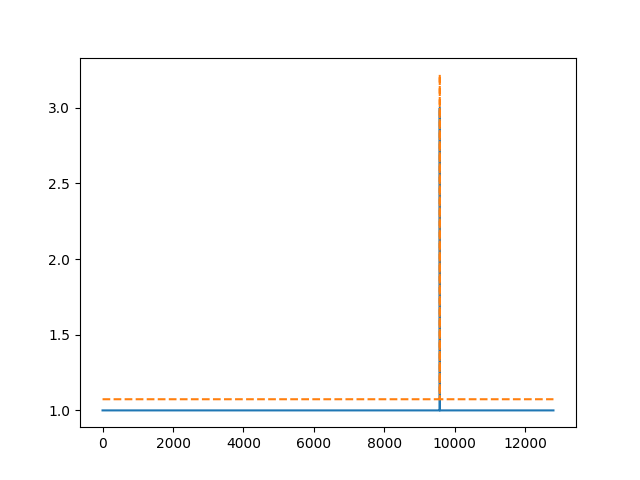

In [3]:
plt.figure()
plt.plot(np.diff(acc_cnt))
plt.plot(np.diff(times), ls="--")
plt.show()

In [4]:
# discontinuous data, add 0s
mask = np.ones(data.shape)

dacc = np.diff(acc_cnt)
dargm = np.argmax(dacc)
print(dacc[dargm])
print(data[dargm-1:dargm+2])
print(times[dargm-1:dargm+2])
print(acc_cnt[dargm-1:dargm+2])

insert_indices = np.where(dacc > 1)[0]
n_insert = dacc[insert_indices] - 1
inserted = 0
for i in range(len(insert_indices)):
    ix = insert_indices[i] + 1 + inserted
    nin = n_insert[i]
    nts = times[ix-1] + (np.arange(nin)+1)*dt
    times = np.insert(times, ix, nts)
    naccs = acc_cnt[ix-1] + np.arange(nin) + 1
    acc_cnt = np.insert(acc_cnt, ix, naccs)
    data = np.insert(data, ix, np.zeros((nin, nchan)), axis=0)
    mask = np.insert(mask, ix, np.zeros((nin, nchan)), axis=0)
    inserted += 1
    
print(data[dargm-1:dargm+4])
print(times[dargm-1:dargm+4])

print(np.allclose(np.diff(acc_cnt), 1))
print(np.allclose(np.diff(times), dt))

3
[[ 784781.5  859709.5  947876.  ... 1218839.5 1224111.  1208682. ]
 [ 807907.   889183.   977141.5 ... 1231435.  1239270.  1229189. ]
 [ 781804.5  846573.   943702.  ... 1210588.5 1219329.5 1206031. ]]
[1.72931422e+09 1.72931422e+09 1.72931422e+09]
[9776 9777 9780]
[[ 784781.5  859709.5  947876.  ... 1218839.5 1224111.  1208682. ]
 [ 807907.   889183.   977141.5 ... 1231435.  1239270.  1229189. ]
 [      0.        0.        0.  ...       0.        0.        0. ]
 [      0.        0.        0.  ...       0.        0.        0. ]
 [ 781804.5  846573.   943702.  ... 1210588.5 1219329.5 1206031. ]]
[1.72931422e+09 1.72931422e+09 1.72931422e+09 1.72931422e+09
 1.72931422e+09]
True
True


In [5]:
# make data a dict to be compatible with hera functions
if type(data) == np.ndarray:
    print("converting to dict")
    data = {"5": data}

converting to dict


divide by zero encountered in log10
invalid value encountered in log10


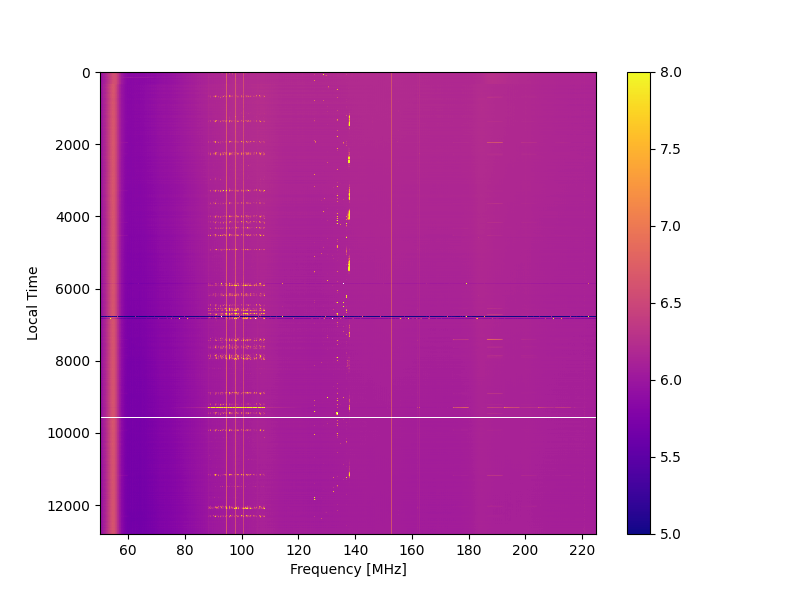

In [43]:
def wfall(data, mode="log", vmin=1e5, vmax=1e8):
    if mode == "log":
        dp = np.log10(data)
        vmin = np.log10(vmin)
        vmax = np.log10(vmax)
    elif mode == "abs":
        dp = np.abs(data)
    else:
        dp = data.copy()
    plt.figure(figsize=(8, 6))
    plt.imshow(dp, aspect="auto", interpolation="none", cmap="plasma", vmin=vmin, vmax=vmax, extent=[freq.min(), freq.max(), len(dts), 0])
    #plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("Local Time")
    plt.colorbar()
    plt.show()

wfall(data["5"])

## Flag brightest RFI

In [65]:
from hera_qm.xrfi import auto_flaggers
from copy import deepcopy

In [66]:
print(df, dt)
INT_COUNT = int(df * dt)
print(INT_COUNT)
print(auto_flaggers)

244140.625 1.0737419128417969
262144
{'dpss_flagger': <function dpss_flagger at 0x7707ece66200>, 'channel_diff_flagger': <function channel_diff_flagger at 0x7707ece662a0>}


In [77]:
def dpss_flagger(data, noise, freqs, filter_centers, filter_half_widths, flags=None,
                 nsig=6, mode="dpss_solve", eigenval_cutoff=[1e-9],
                 suppression_factors=[1e-9], cache=None, return_models=False):
    """
    CHB : rewrite of hera_cal function to return data moddel and noise model

    
    Identify RFI in visibilities by filtering data with discrete prolate spheroidal sequences. Returns a boolean array of flags
    with values of True indicating channels flagged for RFI

    Parameters:
    ----------
    data: np.ndarray
        2D data array of the shape (time, frequency)
    noise: np.ndarray, default=None
        2D array for containing an estimate of the noise standard deviation of the data.
        Must be the same shape as the data.
    freqs: np.ndarray
        1D array of frequencies present in the data in units of Hz
    filter_centers: array-like
        list of floats of centers of delay filter windows in nanosec
    filter_half_widths: array-like
        list of floats of half-widths of delay filter windows in nanosec
    flags: np.ndarray
        2D array of boolean flags to be interpretted as mask for data.
        Must be the same shape as data.
    nsig: float, default=6
        The number of sigma in the metric above which to flag pixels.
    mode: str, default='dpss_solve'
        Method used to solve for DPSS model components. Options are 'dpss_matrix', 'dpss_solve', and 'dpss_leastsq'.
    eigenval_cutoff: array-like, default=[1e-9]
        List of sinc_matrix eigenvalue cutoffs to use for included DPSS modes.
    suppression_factors: array-like, default=[1e-9]
        Specifies the fractional residuals of model to leave in the data. For example, 1e-6 means that the filter
        will leave in 1e-6 of data fitted by the model.
    cache: dictionary, default=None
        Dictionary for caching fitting matrices. By default this value is None to prevent the size of the cached
        matrices from getting too large. By passing in a cache dictionary, this function could be much faster, but
        the memory requirement will also increase.

    Returns:
    -------
    flags: np.ndarray
        Array of boolean flags that has the same shape as the data, where values of True
        indicate flagged channels
    model : np.ndarray
        data model
    sigma : np.ndarray
        noise model
    """
    if len(suppression_factors) == 1 and len(filter_centers) > 1:
        suppression_factors = len(filter_centers) * suppression_factors

    if len(eigenval_cutoff) == 1 and len(filter_centers) > 1:
        eigenval_cutoff = len(filter_centers) * eigenval_cutoff

    if flags is None:
        wgts = np.ones_like(data)
    elif flags is not None and flags.dtype != bool:
        raise TypeError('Input flag array must be type bool')
    else:
        wgts = np.array(np.logical_not(flags), dtype=np.float64)

    # Compute model and residuals
    model, _, _ = hera_filters.dspec.fourier_filter(
        freqs, data, wgts, filter_centers, filter_half_widths, mode=mode,
        suppression_factors=suppression_factors, eigenval_cutoff=eigenval_cutoff, cache=cache,
    )
    res = data - model

    # Use smooth model to noise standard deviation without RFI
    sigma = np.abs(model) * (noise / data)

    # Determine weights
    weights = np.where(res > sigma * nsig, True, False)
    if not return_models:
        return weigths
    return weights, model, sigma

auto_flaggers["dpss_flagger"] = dpss_flagger  # overwrite dpss flagger method

In [78]:
def flag_autos(data, flag_method="channel_diff_flagger", nsig=6, int_count=INT_COUNT, antenna_class=None, flags={},
               flag_broadcast_thresh=0.1, **flag_kwargs):
    """
    CHB: rewrite of hera_qm.xrfi.flag_autos to use numpy array data directly.
    
    Driver function for identifying RFI in auto-correlations. Flags auto-correlations on a per antenna basis using
    a given function and consolidates the weights into a single array-wide weights array. Returns a dictionary of
    boolean flag arrays and an array averaged flag array where channels flagged in "flag_threshold" fraction of antennas
    will be flagged in the array averaged flag array.

    Parameters:
    ----------
    data: DataContainer
        DataContainer containing numpy arrays of auto-correlation data with shape (ntimes, nfreqs)
    flag_method: str, default='channel_diff_flagger'
        Method used for flagging auto-correlations. Current options are 'dpss_flagger' and 'channel_diff_flagger'
    nsig: float, default=6
        The number of sigma in the metric above which to flag pixels.
    int_count: float, default=None
        Number of samples per integration in correlator (dt * dnu)
    antenna_class: AntennaClassification, default=None
        Optional AntennaClassification object. If provided, the flagging method chosen will skip antennas marked "bad"
    flags: dictionary or DataContainer: default={}
        Dictionary or DataContainer containing boolean flag arrays. If flags=None, then no data will be masked
    flag_broadcast_thresh: float, default=0.1
        The fraction of flags required to trigger a broadcast across all auto-correlations for
        a given (time, frequency) pixel in the combined flag array.
    flag_kwargs: dict
        Additional keyword arguments for the function chosen

    Returns:
    -------
    antenna_flags: dictionary
        Dictionary containing boolean flag arrays for each antenna with values of either False or True with
        True identifying channels found to have RFI
    array_flags: np.ndarray
        Contains boolean array of flags for the entire array averaged over all antennas. If antenna_class is provided,
        only antennas labeled 'good' or 'suspect' are included in the average
    """
    # Check to see if flagging method is valid
    if flag_method not in auto_flaggers:
        raise ValueError("Flagging method must be a valid flagging function.")

    alg_func = auto_flaggers[flag_method]

    # Copy flags
    flags = deepcopy(flags)
    antenna_flags = {}

    # Infer int_count from data's metadata if not provided
    if int_count is None:
        raise ValueError
        # int_time = 24 * 3600 * np.median(np.diff(data.times))
        # chan_res = np.median(np.diff(data.freqs))
        # int_count = int(int_time * chan_res)

    array_flags = []

    
    return_models = flag_kwargs.get("return_models", False) and flag_method == "dpss_flagger"
    if return_models:
        dmodels = {}
        nmodels = {}

    # Iterate through data
    for k, v in data.items():
        # Only flag auto-correlations
        if len(k) == 2:
            continue
            
        ant1 = k
        
        # Estimate the noise standard deviation from data
        noise = np.abs(v) / np.sqrt(int_count / 2)

        # Run flagging algorithm
            
        out = alg_func(
                v, noise=noise, nsig=nsig, flags=flags.get(ant1, np.zeros_like(v, dtype=bool)), **flag_kwargs
            )
        if return_models:
            antenna_flags[ant1], dmodels[k], nmodels[k] = out
        else:
            antenna_flags[ant1] = out
        array_flags.append(antenna_flags[ant1])

    # Combine into array-wide weights
    array_flags = np.mean(array_flags, axis=0)
    array_flags = np.where(array_flags < flag_broadcast_thresh, False, True)
    if return_models:
        return antenna_flags, array_flags, dmodels, nmodels
        
    return antenna_flags, array_flags

In [79]:
RFI_NSIG = 4
RFI_DPSS_HALFWIDTH = 300e-9

antenna_flags, array_flags = flag_autos(data, flag_method="channel_diff_flagger", nsig=RFI_NSIG * 5, antenna_class=None, flag_broadcast_thresh=.5)

array_flags1 = deepcopy(array_flags)

divide by zero encountered in log10
invalid value encountered in log10


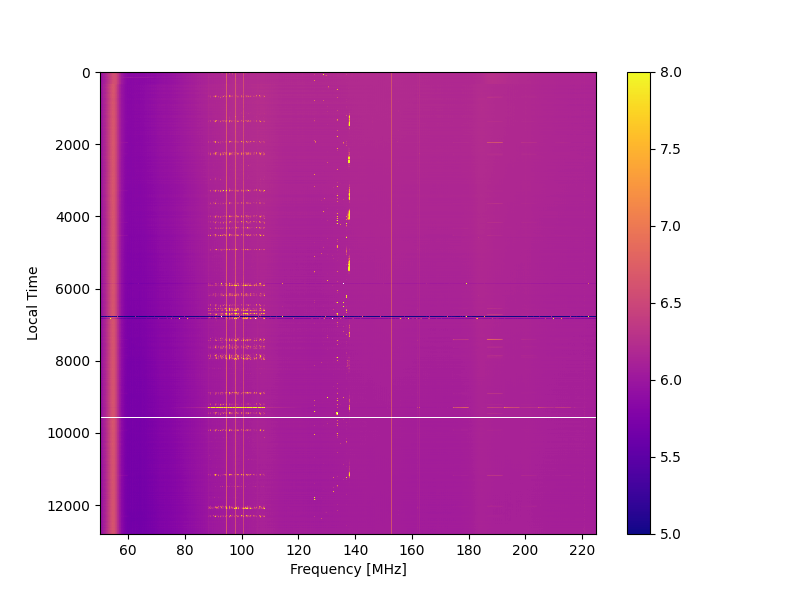

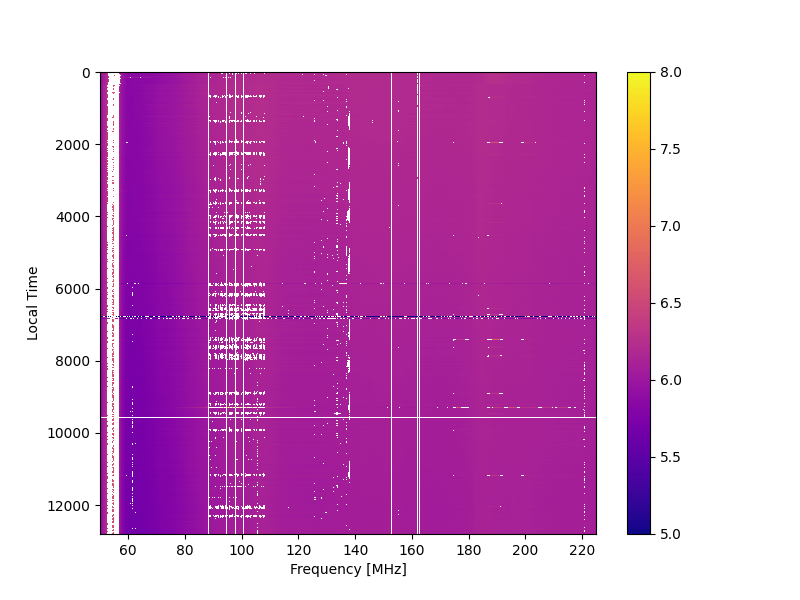

In [80]:
wfall(data["5"])
wfall(data["5"]*~array_flags1)

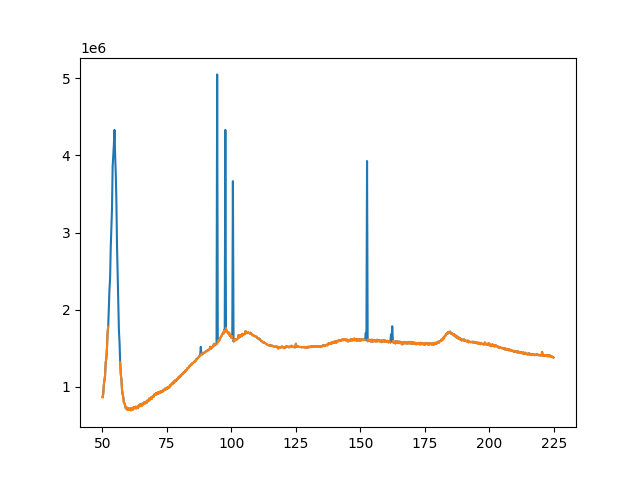

In [81]:
d = data["5"]
plot_ix = 1000
plt.figure()
plt.plot(freq, d[plot_ix])
#plt.plot(freq, d[plot_ix] * ~array_flags[plot_ix])
plt.plot(freq, np.where(array_flags1[plot_ix], np.nan, d[plot_ix]))
plt.show()

In [142]:
RFI_DPSS_HALFWIDTH = 3e-7

In [143]:
for key in antenna_flags:
    antenna_flags[key] = array_flags
    cache = {}
    _, array_flags, dmodels, nmodels = flag_autos(data, freqs=freq_Hz, flag_method="dpss_flagger",
                                     nsig=RFI_NSIG, antenna_class=None,
                                     filter_centers=[0], filter_half_widths=[RFI_DPSS_HALFWIDTH],
                                     eigenval_cutoff=[1e-9], flags=antenna_flags, mode='dpss_matrix', 
                                     cache=cache, flag_broadcast_thresh=.5, return_models=True)

array_flags2 = deepcopy(array_flags)

invalid value encountered in divide


In [89]:
dmdl = dmodels["5"]
nmdl = nmodels["5"]

divide by zero encountered in log10
invalid value encountered in log10


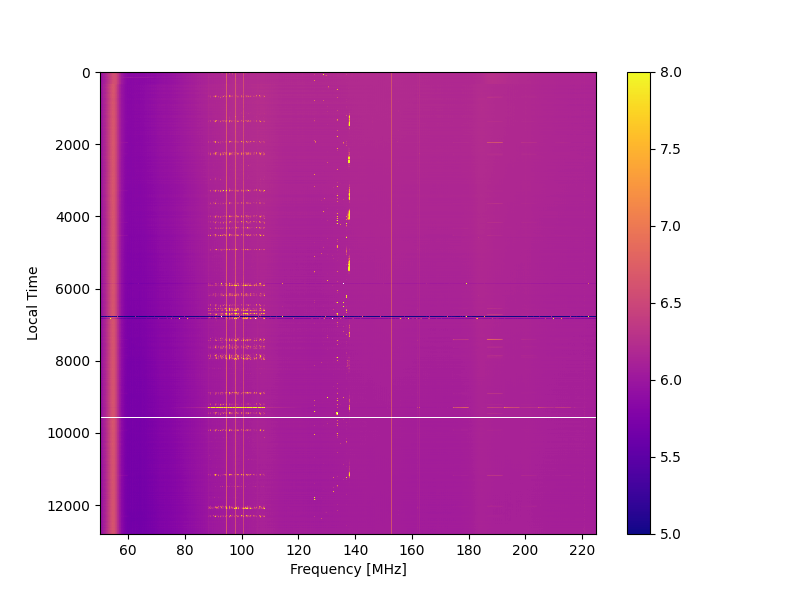

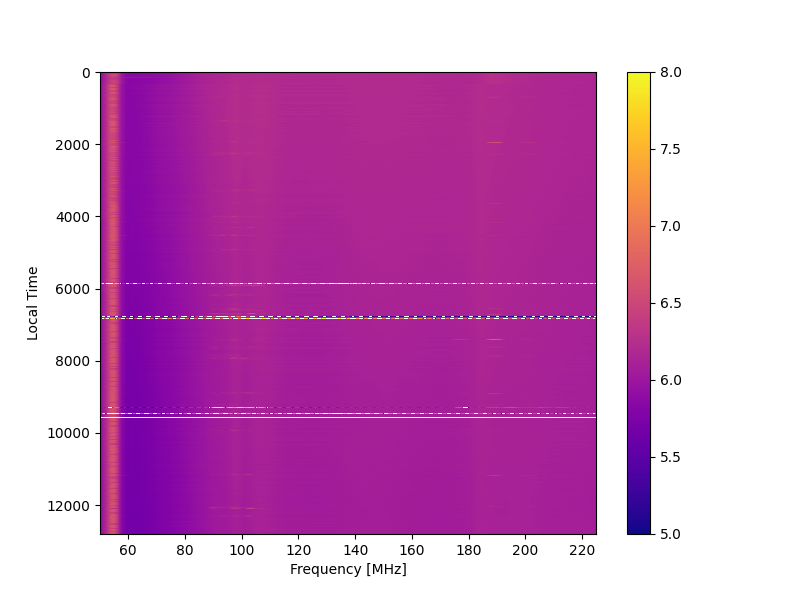

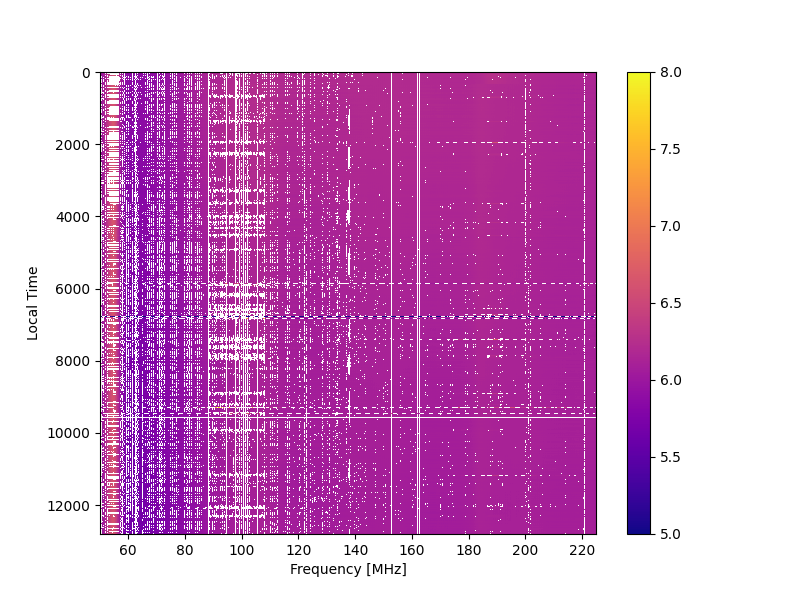

In [90]:
wfall(d)
wfall(dmdl)
wfall(d*~array_flags2)

In [135]:
dmdl/nmdl

array([[362.03867197, 362.03867197, 362.03867197, ..., 362.03867197,
        362.03867197, 362.03867197],
       [362.03867197, 362.03867197, 362.03867197, ..., 362.03867197,
        362.03867197, 362.03867197],
       [362.03867197, 362.03867197, 362.03867197, ..., 362.03867197,
        362.03867197, 362.03867197],
       ...,
       [362.03867197, 362.03867197, 362.03867197, ..., 362.03867197,
        362.03867197, 362.03867197],
       [362.03867197, 362.03867197, 362.03867197, ..., 362.03867197,
        362.03867197, 362.03867197],
       [362.03867197, 362.03867197, 362.03867197, ..., 362.03867197,
        362.03867197, 362.03867197]], shape=(12802, 717))

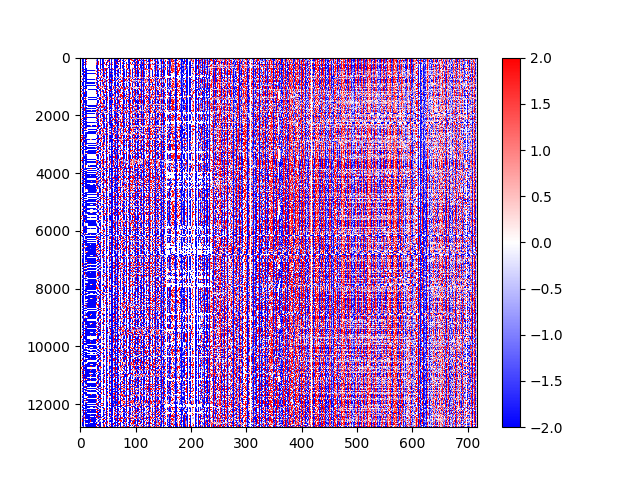

In [138]:
plt.figure()
plt.imshow(np.where(array_flags2, np.nan, (d-dmdl)/nmdl), aspect="auto", cmap="bwr", interpolation="none", vmin=-2, vmax=2)
plt.colorbar()
plt.show()

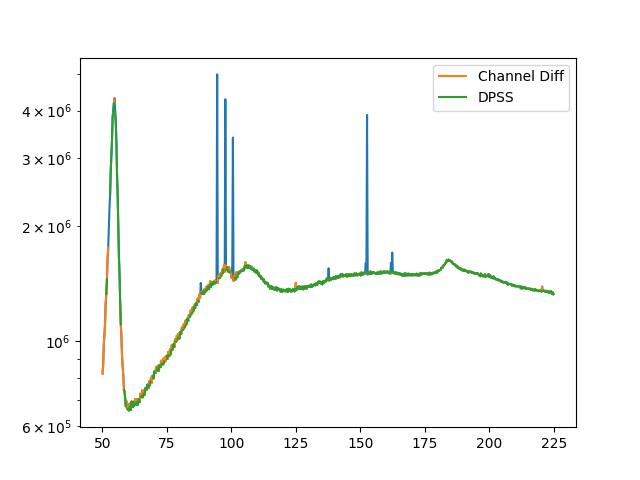

In [91]:
plot_ix = 3150

plt.figure()
plt.plot(freq, d[plot_ix])
plt.plot(freq, np.where(array_flags1[plot_ix], np.nan, d[plot_ix]), label="Channel Diff")
plt.plot(freq, np.where(array_flags2[plot_ix], np.nan, d[plot_ix]), label="DPSS")
plt.legend()
plt.yscale("log")
plt.show()

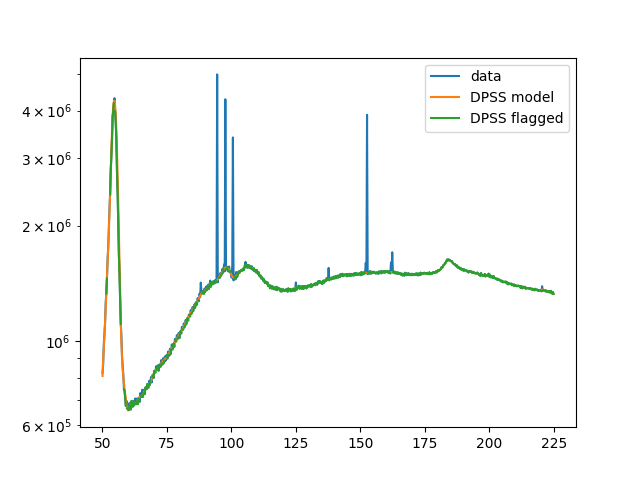

In [122]:
plot_ix = 3150

plt.figure()
plt.plot(freq, d[plot_ix], label="data")
plt.plot(freq, dmdl[plot_ix], label="DPSS model")
plt.plot(freq, np.where(array_flags2[plot_ix], np.nan, d[plot_ix]), label="DPSS flagged")
plt.legend()
plt.yscale("log")
plt.show()

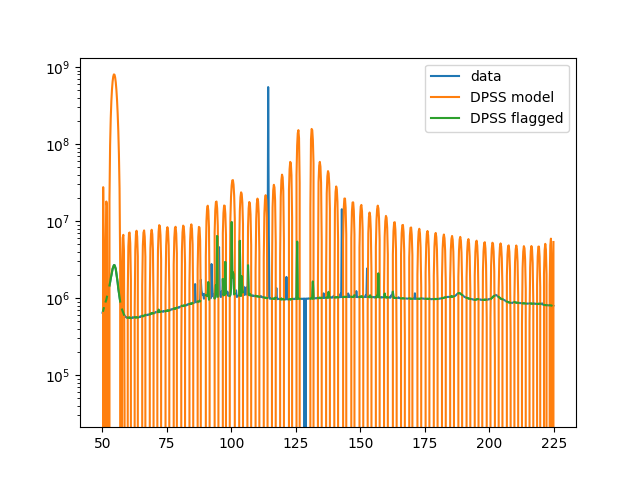

In [123]:
plot_ix = 3101

plt.figure()
plt.plot(freq, d[plot_ix], label="data")
plt.plot(freq, dmdl[plot_ix], label="DPSS model")
plt.plot(freq, np.where(array_flags2[plot_ix], np.nan, d[plot_ix]), label="DPSS flagged")
plt.legend()
plt.yscale("log")
plt.show()

In [109]:
res_noise_ratio

array([[  1.60215512,  -6.28480941,   8.76450501, ...,  -1.30096203,
          1.73274286,  -0.63621469],
       [  1.7938071 ,  -8.2860403 ,  12.55507111, ...,  -2.07628762,
          1.27676786,  -0.31698046],
       [  1.58411193,  -6.84761949,   9.76920378, ...,  -1.17052929,
         -0.12250682,   0.21675648],
       ...,
       [  1.21848402,  -5.64378329,   7.76462816, ...,  -3.32880519,
          0.4340976 ,   0.42478243],
       [  7.71301195, -19.71341849,  10.02568483, ...,  -1.54744587,
         -0.69536063,   0.55418249],
       [  2.55734001, -11.66845404,  14.32582006, ...,  -1.85981334,
         -1.27546916,   0.88521535]], shape=(12802, 717))

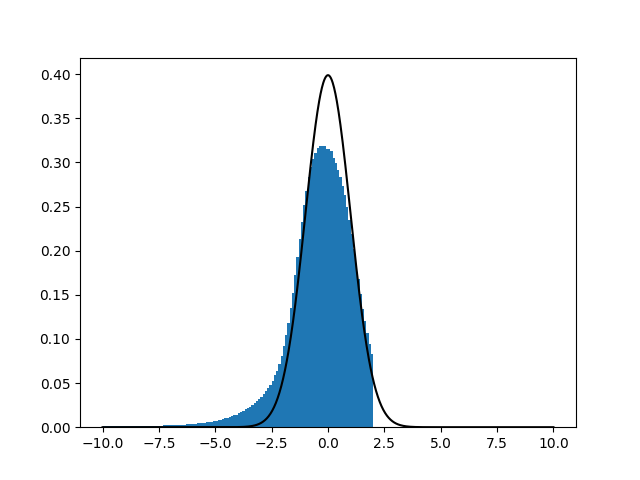

In [131]:
dpss_flagged = np.where(array_flags2, np.nan, d)
#residuals = d - dmdl
residuals = dpss_flagged - dmdl

res_noise_ratio = residuals / nmdl

gx = np.linspace(-10, 10, num=1000)
gy = np.exp(-gx**2/2)
gy /= np.sum(gy * (gx[1] - gx[0]))

plt.figure()
plt.hist(res_noise_ratio.ravel()/2, bins=np.arange(-10, 10, 0.1), density=True)
plt.plot(gx, gy, c="k")
plt.show()

[[363.64082709 355.75386256          nan ... 360.73770994 363.77141483
  361.40245728]
 [363.83247907 353.75263166          nan ... 359.96238434 363.31543983
  361.72169151]
 [363.62278389 355.19105248          nan ... 360.86814268 361.91616515
  362.25542845]
 ...
 [363.25715599 356.39488868          nan ... 358.70986678 362.47276957
  362.46345439]
 [         nan 342.32525347          nan ... 360.4912261  361.34331133
  362.59285446]
 [364.59601198 350.37021793          nan ... 360.17885862 360.76320281
  362.92388732]]


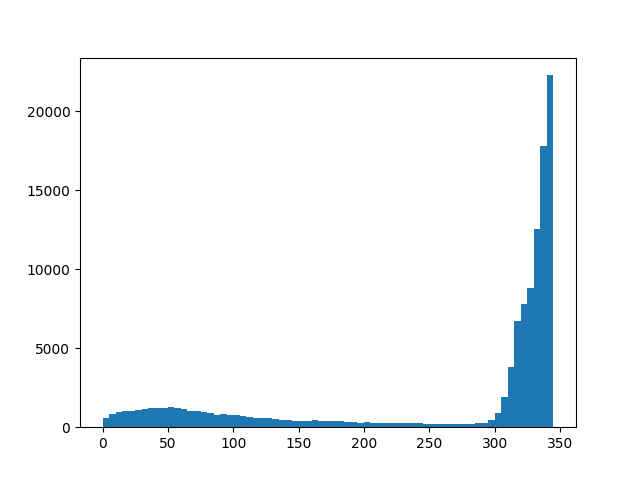

In [99]:
dpss_flagged = np.where(array_flags2, np.nan, d)
data_noise_ratio = dpss_flagged / nmdl

print(data_noise_ratio)

plt.figure()
plt.hist(data_noise_ratio.ravel(), bins=np.arange(0, 350, 5))
plt.show()

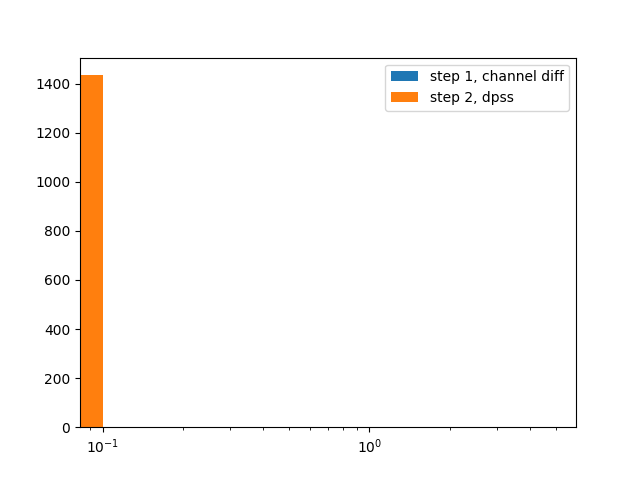

In [61]:
plt.figure()
#plt.hist(dflagged1.ravel(), bins=np.arange(-5, 5, 0.1), label="step 1, channel diff")
plt.hist(np.ravel(dmdl/nmdl), bins=np.arange(-5, 5, 0.1), label="step 2, dpss"
plt.legend()
plt.xscale("log")
plt.show()

In [8]:
# predict noise
print(f"{df=}")
print(f"{dt=}")

def radiometer(data, dt=dt, df=df, auto=True):
    """
    Calculate noise with radiometer equation.
    auto = autocorrelation
    auto False = cross-correlation, differs by a fator of sqrt(2)
    """
    n = data / np.sqrt(dt * df)
    if auto:
        n /= np.sqrt(2)
    return n

noise = radiometer(data)

df=np.float64(244140.625)
dt=np.float64(1.0737419128417969)


In [11]:
freq_Hz

NameError: name 'freq_Hz' is not defined

In [ ]:
d_mdl = np.zeros_like(data)
d_mdl, _, info = dspec.fourier_filter(freq 
                                                           dly_filt_SNRs[bl][:, band], 
                                                           wgts=wgts[:, band], filter_centers=[0], 
                                                           filter_half_widths=[FILTER_DELAY / 1e9], mode='dpss_solve', 
                                                           eigenval_cutoff=[EIGENVAL_CUTOFF], suppression_factors=[EIGENVAL_CUTOFF], 
                                                           max_contiguous_edge_flags=len(hd.freqs), cache=cache)
        dly_filt_SNRs[bl] = np.where(red_avg_flags[bl], 0, red_avg_SNRs[bl] - d_mdl)